*To solve the problem, namely, building a model explaining the traffic on one of the highways for one-hourly intervals based on the training sample and generate predictions for all observations from the test sample in the traffic dataset for regression, several algorithms were used, namely: Linear regression, K-nearest neighbors, as well as random forest. These algorithms were chosen according to the following principle: to begin with, linear regression was applied, as one of the most basic and indicative algorithms performing the function of calculating the linear relationship between the dependent and independent variable, in order to later use this relationship for forecasting. Keys in dictionaries were used as hyperparameters when using a grid.*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt


In [ ]:
df = pd.read_csv('traffic_train.csv')
df.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


</br>The first step is to convert the datetime column

In [ ]:
df['key_1'] = df['date_time'].apply(lambda x: x.split())
df['key_2']= df['key_1'].apply(lambda x: x[0].split('-'))
df['key_3'] = df['key_1'].apply(lambda x: x[0])
df['date'] = pd.to_datetime(df['key_3'])
df['day'] = df['date'].dt.day_name()
df['year'] = df['key_2'].apply(lambda x: int(x[0]))
df['month'] = df['key_2'].apply(lambda x: int(x[1]))

df['key_2']=df['key_1'].apply(lambda x: x[1].split(':'))
df['hour'] = df['key_2'].apply(lambda x: int(x[0]))
df = df.drop(['date_time', 'key_1', 'key_2', 'key_3', 'date'], axis=1)
df.head()

,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,day,year,month,hour
0,Clear,sky is clear,1,11.5,0.0,0.0,508,Wednesday,2014,10,0
1,Clear,sky is clear,1,10.3,0.0,0.0,323,Wednesday,2014,10,1
2,Clear,sky is clear,1,8.0,0.0,0.0,274,Wednesday,2014,10,2
3,Clear,sky is clear,1,7.9,0.0,0.0,372,Wednesday,2014,10,3
4,Clear,sky is clear,1,6.4,0.0,0.0,812,Wednesday,2014,10,4


</br> Assign a numeric value to each day of the week

In [ ]:
mapper = {'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6,
          'Sunday': 7, 'Monday': 1, 'Tuesday': 2}
df = df.replace(mapper)

df.head()

,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,day,year,month,hour
0,Clear,sky is clear,1,11.5,0.0,0.0,508,3,2014,10,0
1,Clear,sky is clear,1,10.3,0.0,0.0,323,3,2014,10,1
2,Clear,sky is clear,1,8.0,0.0,0.0,274,3,2014,10,2
3,Clear,sky is clear,1,7.9,0.0,0.0,372,3,2014,10,3
4,Clear,sky is clear,1,6.4,0.0,0.0,812,3,2014,10,4


</br>Correlation between variables. The strongest correlation in traffic is observed with the hour.

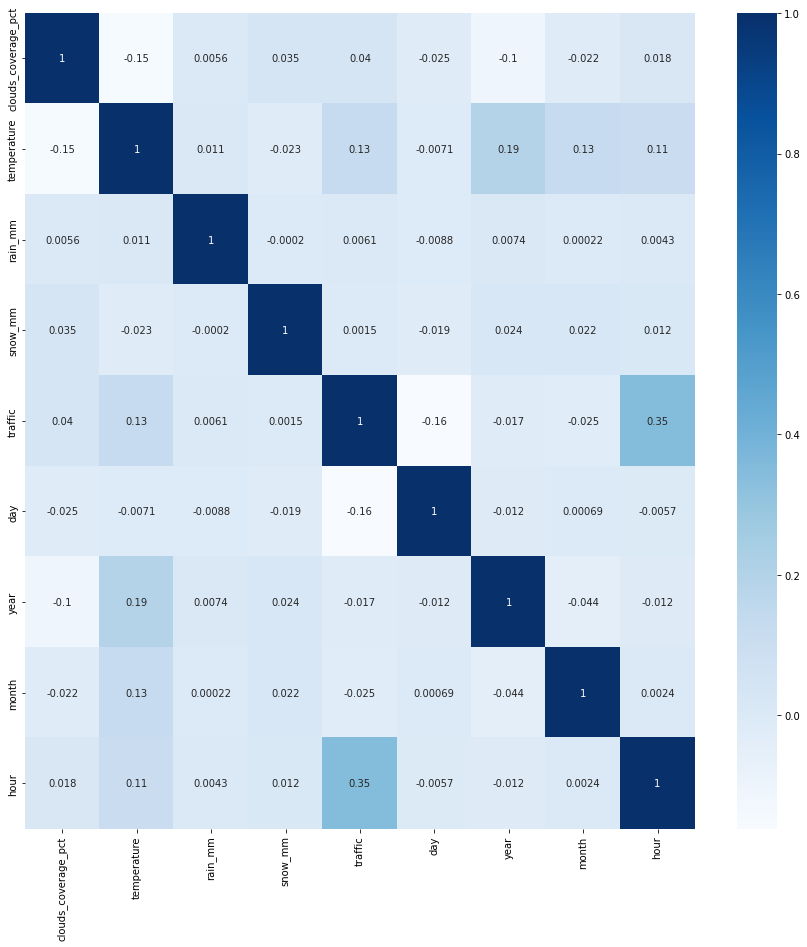

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues');

</br>It is necessary to get rid of zeros and set two variables: x - for traffic and y - for everything else

In [ ]:
df = df.drop(df[df['traffic'] == 0].index)
y = df['traffic'] 
x = df.drop(columns=['traffic'], axis=1)
x = x[['clouds_coverage_pct', 'temperature', 'rain_mm',
       'snow_mm', 'day', 'year', 'month', 'hour']]

</br>Histogram showing traffic during the day. The biggest indicators are observed during the so-called rush hours, at 7 am and at 4 pm.

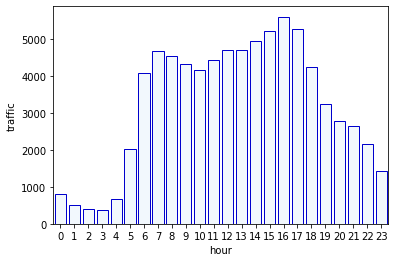

In [ ]:
sns.barplot(x='hour',y='traffic', data=df, ci=None,
           color='aliceblue',
           edgecolor='mediumblue',
           lw=1)

</br>Traffic on different days of the week. On working days, traffic is more frequent than on weekends.

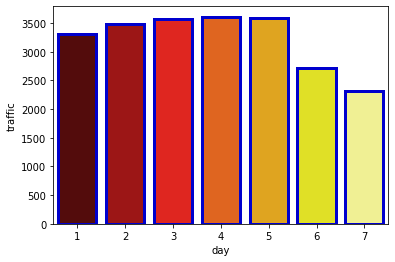

In [ ]:
sns.barplot(x='day',y='traffic', data=df, ci=None,
           color='aliceblue',
           edgecolor='mediumblue',
           palette='hot',
           lw=3)

</br> Traffic distribution under different weather conditions. We notice some changes in traffic with a deterioration in weather conditions

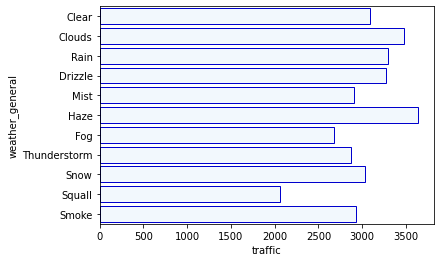

In [ ]:
sns.barplot(x='traffic',y='weather_general', data=df, ci=None,
           color='aliceblue',
           edgecolor='mediumblue',
           lw=1)

</br>Next, we make a division into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

## </br> Linear Regression

</br>To begin with, we use linear regression to illustrate the results. We get the following results:

In [ ]:
lR = LinearRegression()
cv_results = cross_validate(lR, x, y, cv=4, scoring='neg_mean_absolute_percentage_error')
cv_results['test_score']

array([-1.42433501, -1.34799367, -1.42825708, -4.22672909])

</br> Using the final result of linear regression, MAPE turned out to be 1.98, which is an extremely large value

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(mean_absolute_percentage_error(y_test,pred))

1.9836165961274104


## </br> KNN

The second algorithm was chosen K-nearest neighbors, the essence of which is that if most of the k most similar samples (that is, the closest neighbors in the feature space) of the samples in the feature space belong to a certain category, the sample also belongs to this category. The advantages of this algorithm include accuracy, as well as suitability for rare events. One of the disadvantages is that the algorithm calculates only the "nearest" neighbor samples, and a certain number of samples is large, then such samples are not close to the target samples, or such samples are close to the target samples. Regardless of the fact that the number does not affect the results of the operation. As a result of applying this algorithm and comparing it with the original model, a value of 0.44 was obtained.

</br> We use cross-validation in order to understand what errors we have

In [ ]:
model = KNeighborsRegressor()
cv_results = cross_validate(model, x, y, cv=4, scoring='neg_mean_absolute_percentage_error')

</br> The following results were obtained

In [ ]:
cv_results['test_score']

array([-0.40913218, -0.47755346, -0.45816443, -3.07808773])

</br> We use randomized search to select random pairs of parameters from the grid (random_grid) and designate the best model (2,2,1). 

In [ ]:
random_grid = {'n_neighbors': list(range(1,50)),
               'leaf_size': list(range(1,50)), 
               'p': [1, 2]}
knn = KNeighborsRegressor()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
knn_random.fit(X_train, y_train)
knn_random.best_params_

{'leaf_size': 43, 'n_neighbors': 4, 'p': 2}

</br> Next, we compare the usual model with the one that selects the best parameters. 
As a result, we get 0.76 for the standard model and 0.44 for the improved one.

In [ ]:
knn_base = KNeighborsRegressor()
knn_base.fit(X_train, y_train)
pred = knn_base.predict(X_test)
print(mean_absolute_percentage_error(y_test,pred))

knn_best = knn_random.best_estimator_
pred = knn_best.predict(X_test)
print(mean_absolute_percentage_error(y_test,pred))

0.7686273601179997
0.7681815066641401


</br> Next, narrow the search area and re-apply grid_search for 48 options. 
No improvement in the result was noticed.

In [ ]:
param_grid = {'n_neighbors': [x for x in range(1,3)],
               'leaf_size': [x for x in range(1,5)],
              'p': [1, 2]}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'leaf_size': 2, 'n_neighbors': 1, 'p': 1}

</br> We get a predictive performance result equal to 0.44.

In [ ]:
knn_best = grid_search.best_estimator_
pred = knn_best.predict(X_test)
print(mean_absolute_percentage_error(y_test,pred))

0.4401208552476486


## </br> The final algorithm applied: Random Forest

A random forest was chosen as the final and most efficient algorithm. The advantage of this algorithm is that it is quite versatile and quite suitable for solving our problem. This is a set of decision trees. The principle is that in the regression problem, their responses are averaged. This algorithm is the most effective and allowed to achieve the final result in 0.39

In [ ]:
model = RandomForestRegressor()
cv_results = cross_validate(model, x, y, cv=4, scoring='neg_mean_absolute_percentage_error')

</br>After application, we get the following results:

In [ ]:
cv_results['test_score']

array([-0.12657399, -0.13533993, -0.28541921, -2.82749436])

</br>Narrowing the search area

In [ ]:
param_grid = {
    'max_depth': [x for x in range(40, 90, 5)],
    'min_samples_split': [x for x in range(2,10)],
    'n_estimators': [x for x in range(1,10)],
    'min_samples_leaf': [x for x in range(1,10)]
}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
rf_random.fit(X_train, y_train)
rf_random.best_params_



{'max_depth': 65,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 2}

</br>Then, as the final result, we get a predicative performance equal to 0.39

In [ ]:
rf_base = RandomForestRegressor()
rf_base.fit(X_train, y_train)
pred = rf_base.predict(X_test)
print(mean_absolute_percentage_error(y_test,pred))

rf_best = rf_random.best_estimator_
pred = rf_best.predict(X_test)
print(mean_absolute_percentage_error(y_test,pred))

0.4032702178891249
0.4979715738001617
